<a href="https://colab.research.google.com/github/RichardXiao13/Google_Code_In/blob/master/Background_Remover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import tensorflow.

In [1]:
try:
  %tensorflow_version 2.x
except:
  Exception
import tensorflow as tf

TensorFlow 2.x selected.


Import layers from tensorflow. keras API.

In [0]:
import tensorflow.keras.layers as layers

Define a function that creates the blocks of layers specified for the tiramisu model. It consists of Batch Normalization, ReLU, 3 x 3 Convolution, and a Dropout layer where p = 0.2.

In [0]:
def block(x, num_layers):
  for i in range(num_layers):
    t = x
    x = layers.BatchNormalization(axis=1, beta_regularizer=tf.keras.regularizers.l2(0.0001), gamma_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(16, (3, 3), padding="same", kernel_initializer="he_uniform")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.concatenate([x, t])
  return x

Define a transition down function which creates the layers in the transition down blocks for the model. It consists of Batch Normalization, ReLU, 1 x 1 Convolution, Dropout where p = 0.2, and a 2 x 2 Max Pooling layer.

In [0]:
def transition_down(x, num_features):
    x = layers.BatchNormalization(axis=1, beta_regularizer=tf.keras.regularizers.l2(0.0001), gamma_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(num_features, (1, 1), padding="same", kernel_initializer="he_uniform")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D((2, 2), strides=2, padding="same")(x)
    return x

Define a transition up function which creates the layers for the transition up blocks in the model. It consists of a 3 x 3 Transposed Convolution where the stride = 2.

In [0]:
def transition_up(x, num_features):
  x = layers.Conv2DTranspose(num_features, strides=2, kernel_size=(3, 3), padding="same")(x)
  return x

Define a function that creates a tiramisu model. The transition up blocks are contained within this function.

In [0]:
def create_tiramisu(layer_per_block):
  n_pool = 5
  growth_rate = 16
  num_features = 48
  input_layer = layers.Input((224, 224, 3))
  x = layers.Conv2D(48, (3, 3), padding="same")(input_layer)
  skip_connections = []
  for i in range(n_pool):
    x = block(x, layer_per_block[i])
    skip_connections.append(x)
    num_features += growth_rate * layer_per_block[i]
    x = transition_down(x, num_features)

  x = block(x, layer_per_block[n_pool])
  skip_connections = skip_connections[::-1]

  for i in range(n_pool):
    num_features = growth_rate * layer_per_block[n_pool + i]
    x = transition_up(x, num_features)
    x = layers.concatenate([x, skip_connections[i]])
    x = block(x, layer_per_block[n_pool+i+1])

  x = layers.Conv2D(2, kernel_size=(1, 1), padding='same', kernel_initializer="he_uniform")(x)
  output_layer = layers.Activation('softmax')(x)
  return tf.keras.Model(inputs=input_layer, outputs=output_layer)

Create the tiramisu model with 103 layers.

In [0]:
model_layers = [4, 5, 7, 10, 12, 15, 12, 10, 7, 5, 4]
tiramisu = create_tiramisu(model_layers)

Download the Matting Human Datasets for segmentation. Then extract the zip into the workspace.

In [0]:
import os

In [9]:
os.environ['KAGGLE_USERNAME'] = "richardx13"
os.environ['KAGGLE_KEY'] = "a27f04dddeebb3312cf29c0463cd0ab0"
!kaggle datasets download -d laurentmih/aisegmentcom-matting-human-datasets

100% 28.7G/28.8G [08:13<00:00, 36.5MB/s]
100% 28.8G/28.8G [08:13<00:00, 62.5MB/s]


In [0]:
import zipfile
with zipfile.ZipFile("/content/aisegmentcom-matting-human-datasets.zip","r") as zip_ref:
    zip_ref.extractall("/content/")

Create a function that reads in the folder with the PNG images to extract the alpha layers from them. 

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [0]:
def extract_alpha(directory):
  alphas = []
  for folder1 in sorted(os.listdir(directory)):
    print(folder1)
    for filename in sorted(os.listdir(os.path.join(directory, folder1)))[:30]:
      img = tf.image.resize(plt.imread(os.path.join(directory, folder1, filename)), (224, 224))
      img = img[:,:,3]
      img = img.numpy()
      for i in range(224):
        for j in range(224):
          img[i,j] = round(img[i,j])
      alphas.append(img)
  return alphas

In [13]:
alphas = extract_alpha("/content/matting_human_half/matting/1803151818/")

matting_00000000
matting_00000001
matting_00000002
matting_00000003
matting_00000004
matting_00000005
matting_00000006
matting_00000007
matting_00000008
matting_00000009
matting_00000010
matting_00000011
matting_00000012
matting_00000013
matting_00000014
matting_00000015
matting_00000016
matting_00000017
matting_00000018
matting_00000019
matting_00000020
matting_00000021
matting_00000022
matting_00000023


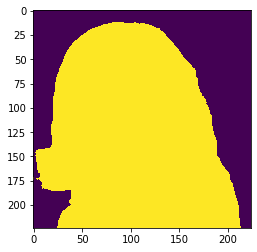

In [14]:
plt.imshow(alphas[0])

Define a function that stores the corresponding images to the alpha maps extracted above in JPG format.

In [0]:
def extract_imgs(directory):
  imgs = []
  for folder1 in sorted(os.listdir(directory)):
    print(folder1)
    for filename in sorted(os.listdir(os.path.join(directory, folder1)))[:30]:
      img = tf.image.resize(plt.imread(os.path.join(directory, folder1, filename)), (224, 224))/255
      imgs.append(img)
  return imgs

In [16]:
imgs = extract_imgs("/content/matting_human_half/clip_img/1803151818")

clip_00000000
clip_00000001
clip_00000002
clip_00000003
clip_00000004
clip_00000005
clip_00000006
clip_00000007
clip_00000008
clip_00000009
clip_00000010
clip_00000011
clip_00000012
clip_00000013
clip_00000014
clip_00000015
clip_00000016
clip_00000017
clip_00000018
clip_00000019
clip_00000020
clip_00000021
clip_00000022
clip_00000023


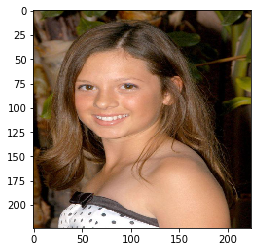

In [17]:
plt.imshow(imgs[0])

Create a dataset that takes the images as labels and the alpha maps as outputs. Then batch the dataset.

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((imgs, alphas))

In [0]:
train_set = dataset.batch(10).prefetch(1)

Compile the model and set the training for 5 epochs.

In [0]:
EPOCHS = 5

tiramisu.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Train the model on the segmentations. Once training is finished, save the model as a .h5 file.

In [0]:
history = tiramisu.fit(train_set, epochs=EPOCHS)

In [0]:
tiramisu.save("new_tiramisu.h5")

Now, we choose some test data to see how well our model performs.

In [0]:
img_path = "/content/matting_human_half/matting/1803151818/matting_00000001"
imgs_test = []
for img in os.listdir(img_path)[:5]:
  image = plt.imread(os.path.join(img_path, img))
  imgs_test.append(tf.image.resize(image, (224, 224)))

In [0]:
jpg_path = "/content/matting_human_half/clip_img/1803151818/clip_00000001"
jpg_test = []
for img in os.listdir(jpg_path)[:5]:
  image = plt.imread(os.path.join(jpg_path, img))
  jpg_test.append(tf.image.resize(image, (224, 224)))

Here, we put the test data into a dataset and batch it for predictions.

In [0]:
test_data = tf.data.Dataset.from_tensor_slices((jpg_test))
test_data = test_data.batch(len(jpg_test))

In [0]:
predictions = tiramisu.predict(test_data)

# **True Labels**

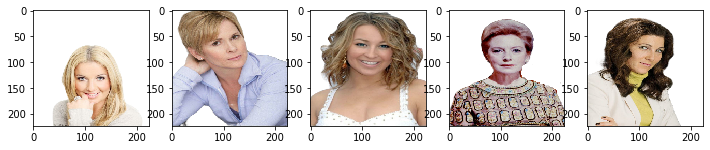

In [74]:
plt.figure(figsize=(12, 12))

for i in range(len(imgs_test)):
  plt.subplot(1, 5, i+1)
  plt.imshow(imgs_test[i])

# **Corresponding Predictions**

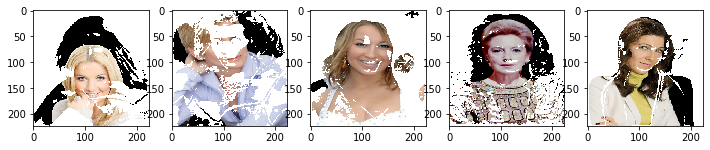

In [92]:
plt.figure(figsize=(12, 12))

for i in range(len(imgs_test)):
  mask = tf.argmax(predictions[i], axis=-1)
  imgs_test[i] = imgs_test[i].numpy()
  imgs_test[i][:,:,3] = mask
  plt.subplot(1, 5, i+1)
  plt.imshow(imgs_test[i])

plt.show()

# **Results**
Looking at the predictions, we can see that our model didn't perform as well as we would have liked. Some solutions to this would be to use more training data. In this test, we chose a small subset of data to reduce training times from Colab's restrictions. We could also increase the batch size for better generalization while also increasing the training epoch count. Then, we could use a validation set to see if our model was overfitting and when it would occur.